In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from warnings import simplefilter
# simplefilter("ignore")  # ignore warnings to clean up output cells

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [3]:
!pip install scikit-multiflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.0 MB/s eta 0:00:00a 0:00:01


In [4]:
!pip install creme


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.0 MB/s eta 0:00:00a 0:00:010m
  Preparing metadata (setup.py) ... done
  Created wheel for mmh3: filename=mmh3-2.5.1-cp37-cp37m-linux_x86_64.whl size=49216 sha256=7c12983be9f57f1790427f219dabd8024a7b0dd0bbe949e13faf942e8f35fc0b
  Stored in directory: /root/.cache/pip/wheels/ae/45/25/90e097a519143b2dca74cd93a056894a965f27908103e01799
Successfully built mmh3
  Attempting uninstall: mmh3
    Found existing installation: mmh3 3.0.0
    Uninstalling mmh3-3.0.0:
      Successfully uninstalled mmh3-3.0.0


In [5]:
!pip install river

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.0 MB/s eta 0:00:0000:0100:010m


In [ ]:
!pip install pmdarima

In [6]:
import river
import creme
import skmultiflow

### TODO
-   https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/
- How learning parameters from one training data works mathematically?


In [7]:
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.stattools import adfuller

# from datetime import datetime
mpl.rcParams['figure.figsize'] = (14, 8)
mpl.rcParams['axes.grid'] = False

In [89]:
import xgboost as xgb
# from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split as ttsplit
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.base import clone
import copy


In [8]:
# Load data
df_store = pd.read_csv("/kaggle/input/rossmann-store-sales/store.csv")
df_train = pd.read_csv("/kaggle/input/rossmann-store-sales/train.csv", parse_dates=["Date"])
df_test = pd.read_csv("/kaggle/input/rossmann-store-sales/test.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [10]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [11]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [14]:
print(f"Number of stores: {df_train.Store.nunique()}")

Number of stores: 1115


In [15]:
# df_test.head()

In [42]:
# Taking only 1 store to work on: 

df_store_1 = df_train.query("Store == 1")
df_store_1

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1011635,1,6,2013-01-05,4997,635,1,0,0,1
1012750,1,5,2013-01-04,4486,619,1,0,0,1
1013865,1,4,2013-01-03,4327,578,1,0,0,1
1014980,1,3,2013-01-02,5530,668,1,0,0,1


In [17]:
# Original version of dataframe
df_store_1_nonIdx = df_store_1.copy()

In [43]:
# Useful for many cases
df_store_1 = df_store_1.set_index('Date')

In [19]:
df_store_1.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


In [44]:
# Increasing order by Date col
df_store_1.sort_values(by="Date", inplace=True)

In [45]:
df_store_1.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1
2013-01-02,1,3,5530,668,1,0,0,1
2013-01-03,1,4,4327,578,1,0,0,1
2013-01-04,1,5,4486,619,1,0,0,1
2013-01-05,1,6,4997,635,1,0,0,1


In [22]:
# Checking for Nulls
df_store_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          942 non-null    int64 
 1   DayOfWeek      942 non-null    int64 
 2   Sales          942 non-null    int64 
 3   Customers      942 non-null    int64 
 4   Open           942 non-null    int64 
 5   Promo          942 non-null    int64 
 6   StateHoliday   942 non-null    object
 7   SchoolHoliday  942 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 66.2+ KB


In [23]:
# Basic Distribution of data
df_store_1.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,942.0,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000
mean,1.0,3.997877,3945.704883,467.646497,0.829087,0.382166,0.204883
std,0.0,1.998404,2015.417840,228.930850,0.376633,0.486175,0.403831
min,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,2.000000,3588.250000,463.000000,1.000000,0.000000,0.000000
50%,1.0,4.000000,4373.500000,529.000000,1.000000,0.000000,0.000000
75%,1.0,6.000000,5220.000000,598.750000,1.000000,1.000000,0.000000
max,1.0,7.000000,9528.000000,1130.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='Date'>

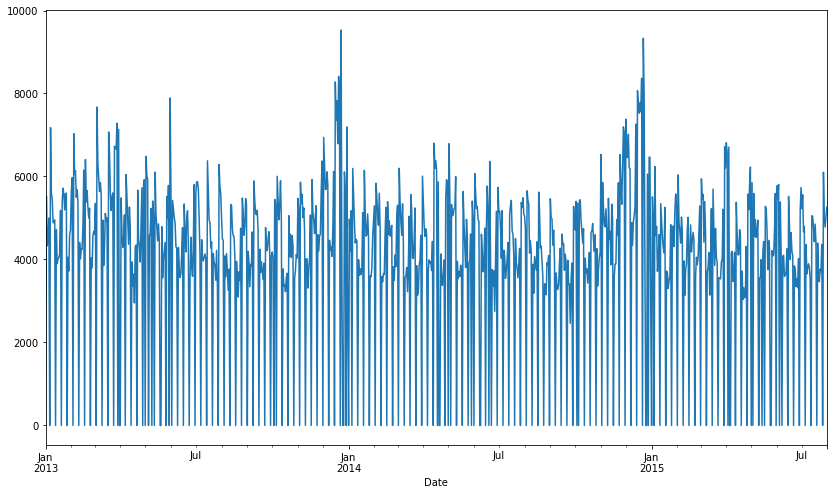

In [24]:
# Plot : X -> Date, Y -> Sales

sales = df_store_1["Sales"]
sales.plot()

<AxesSubplot:xlabel='Date'>

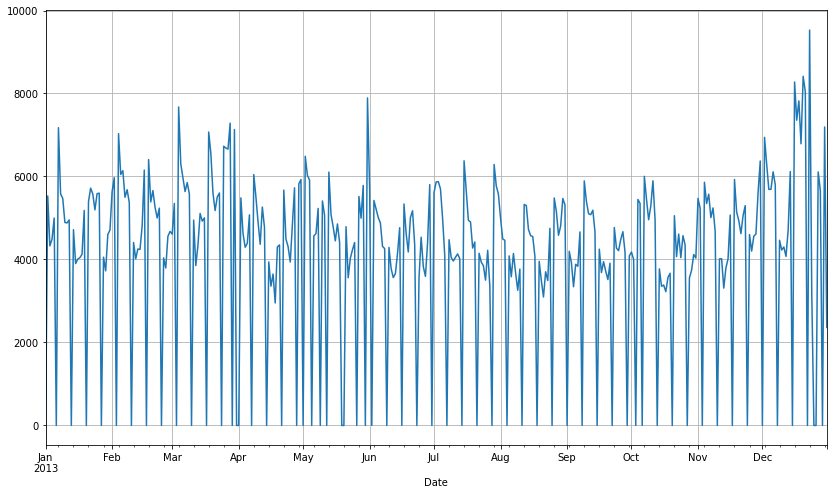

In [25]:
# Subsetting only 1 year of Sales
sales['2013'].plot(grid=True)

<AxesSubplot:xlabel='Date'>

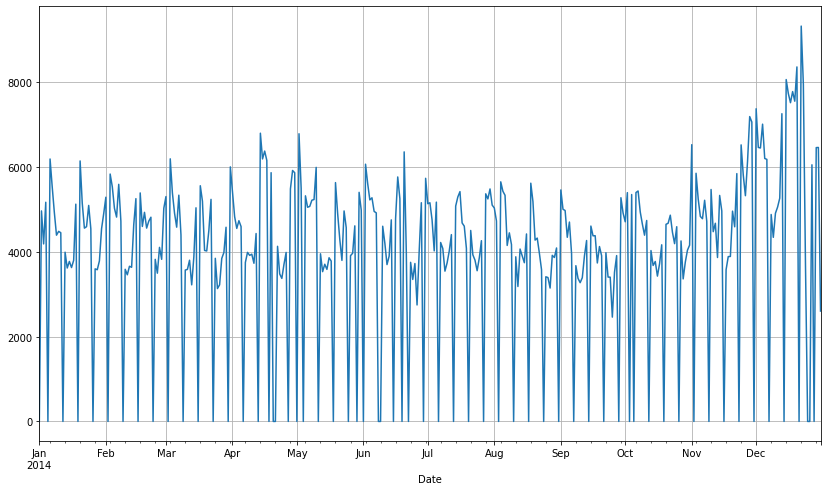

In [26]:
# Subsetting only 1 year of Sales

sales['2014'].plot(grid=True)

In [27]:
# Interactive Plot with Plotly Express

import plotly.express as px

fig = px.line(df_store_1_nonIdx, x='Date', y='Sales', title='Store 1: Sales with Slider')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

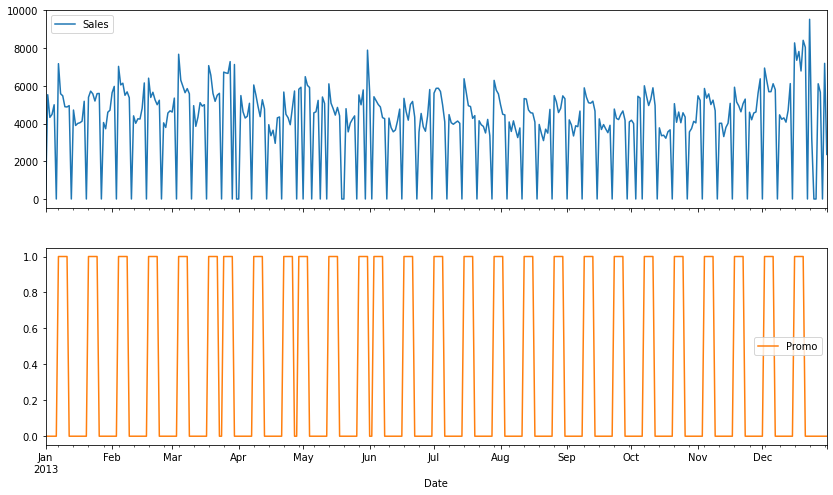

In [28]:
# Multivariate Plot of a Year data: Sales and Promo

df_2013 = df_store_1["2013"]
prom_df_2013 = df_2013[["Sales", "Promo"]]
prom_df_2013.plot(subplots=True)


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

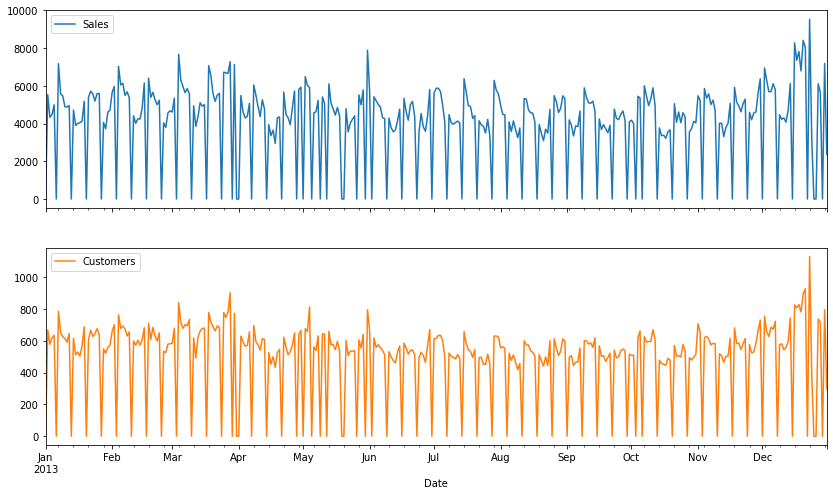

In [29]:
# Multivariate Plot of a Year data: Sales and Customers

customer_df_2013 = df_2013[["Sales", "Customers"]]
customer_df_2013.plot(subplots=True)

<AxesSubplot:xlabel='Date'>

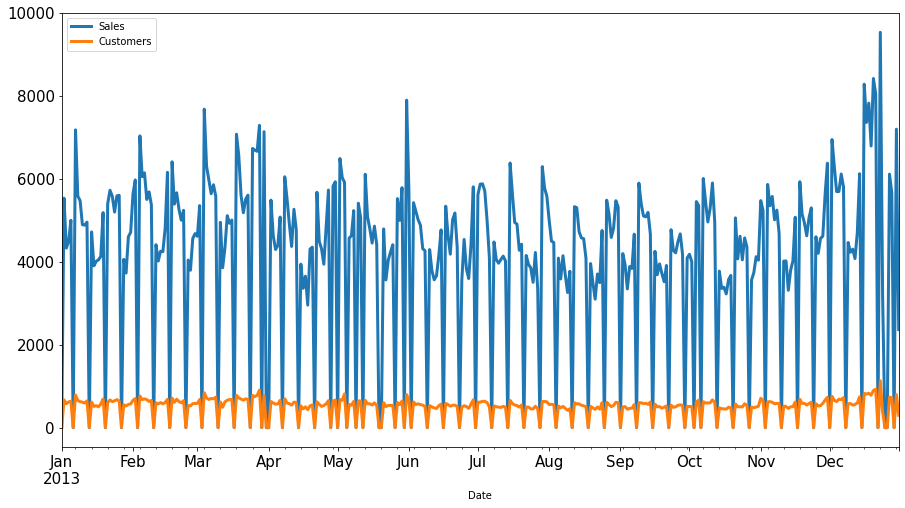

In [30]:
#  Multivariate Plot Overlay : Sales and Customer

customer_df_2013 = df_2013[["Sales", "Customers"]]
customer_df_2013.plot(figsize=(15,8), linewidth=3, fontsize=15)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



<AxesSubplot:xlabel='Date'>

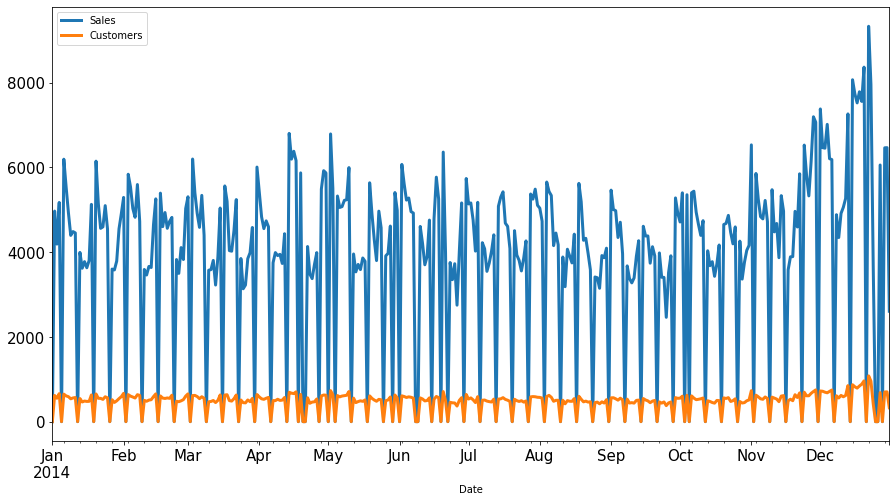

In [31]:
#  Multivariate Plot Overlay : Sales and Customer

df_2014 = df_store_1["2014"]

customer_df_2014 = df_2014[["Sales", "Customers"]]
customer_df_2014.plot(figsize=(15,8), linewidth=3, fontsize=15)

In [25]:
# df_2014

In [32]:
# Extract Features From Date column

def create_features(df, label=None):
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    return df.drop(columns=["date"], axis="column")

In [46]:
df_store_1 = create_features(df_store_1)
df_store_1.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1,1,1,1,2013,1,1,1
2013-01-02,1,3,5530,668,1,0,0,1,2,1,1,2013,2,2,1
2013-01-03,1,4,4327,578,1,0,0,1,3,1,1,2013,3,3,1
2013-01-04,1,5,4486,619,1,0,0,1,4,1,1,2013,4,4,1
2013-01-05,1,6,4997,635,1,0,0,1,5,1,1,2013,5,5,1


In [47]:
# Select important cols
print(df_store_1.columns)

# We only have One Store = 1
df_store_1 = df_store_1.drop("Store", axis=1)


Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')


In [48]:
# Creating Lag features

df_store_1["Lag_1"] = df_store_1["Sales"].shift(1)
df_store_1["Lag_2"] = df_store_1["Sales"].shift(2)
df_store_1["Lag_3"] = df_store_1["Sales"].shift(3)
df_store_1["Lag_4"] = df_store_1["Sales"].shift(4)
df_store_1["Lag_5"] = df_store_1["Sales"].shift(5)
df_store_1["Lag_6"] = df_store_1["Sales"].shift(6)
df_store_1["Lag_7"] = df_store_1["Sales"].shift(7)
df_store_1["Lag_8"] = df_store_1["Sales"].shift(8)

df_store_1 = df_store_1.dropna()

df_store_1.head()

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,dayofweek,quarter,month,...,dayofmonth,weekofyear,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-09,3,5471,626,1,1,0,1,2,1,1,...,9,2,5580.0,7176.0,0.0,4997.0,4486.0,4327.0,5530.0,0.0
2013-01-10,4,4892,615,1,1,0,1,3,1,1,...,10,2,5471.0,5580.0,7176.0,0.0,4997.0,4486.0,4327.0,5530.0
2013-01-11,5,4881,592,1,1,0,1,4,1,1,...,11,2,4892.0,5471.0,5580.0,7176.0,0.0,4997.0,4486.0,4327.0
2013-01-12,6,4952,646,1,0,0,0,5,1,1,...,12,2,4881.0,4892.0,5471.0,5580.0,7176.0,0.0,4997.0,4486.0
2013-01-13,7,0,0,0,0,0,0,6,1,1,...,13,2,4952.0,4881.0,4892.0,5471.0,5580.0,7176.0,0.0,4997.0


In [49]:
# Correlation between Features Check

import matplotlib.pyplot as plt

corr = df_store_1.corr()
corr.style.background_gradient(cmap='coolwarm')



,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8
DayOfWeek,1.000000,-0.503285,-0.497939,-0.547689,-0.391406,-0.067250,1.000000,-0.009374,-0.007241,0.000701,-0.006824,0.004710,-0.005380,0.474988,0.225757,0.086545,0.050252,-0.075125,-0.257436,-0.504009,0.475095
Sales,-0.503285,1.000000,0.984323,0.888965,0.470992,0.007304,-0.503285,0.039617,0.047053,-0.065937,0.044754,-0.027923,0.044143,-0.124279,-0.033652,0.064765,0.000363,-0.115769,-0.227900,0.633945,-0.242484
Customers,-0.497939,0.984323,1.000000,0.927770,0.377572,-0.001888,-0.497939,0.012921,0.019765,-0.086678,0.018365,-0.020242,0.019417,-0.133589,-0.057624,0.047844,-0.006276,-0.104310,-0.234615,0.689539,-0.203716
Open,-0.547689,0.888965,0.927770,1.000000,0.298497,0.003528,-0.547689,0.004314,-0.001983,-0.006272,0.000286,0.023301,0.002330,-0.170035,-0.167320,-0.043771,-0.081248,-0.156951,-0.226230,0.709436,-0.169998
Promo,-0.391406,0.470992,0.377572,0.298497,1.000000,0.033650,-0.391406,-0.008185,-0.013574,0.021817,-0.023940,-0.118732,-0.000977,0.099295,0.121025,0.058515,-0.077411,-0.222355,0.095679,0.024534,-0.313558
SchoolHoliday,-0.067250,0.007304,-0.001888,0.003528,0.033650,1.000000,-0.067250,0.196356,0.134846,-0.074734,0.137075,0.035084,0.099770,-0.043671,-0.022565,-0.027739,-0.016697,-0.010492,0.064786,0.073857,0.029215
dayofweek,1.000000,-0.503285,-0.497939,-0.547689,-0.391406,-0.067250,1.000000,-0.009374,-0.007241,0.000701,-0.006824,0.004710,-0.005380,0.474988,0.225757,0.086545,0.050252,-0.075125,-0.257436,-0.504009,0.475095
quarter,-0.009374,0.039617,0.012921,0.004314,-0.008185,0.196356,-0.009374,1.000000,0.968962,-0.261719,0.965873,0.000814,0.939669,0.042966,0.031268,0.029155,0.033901,0.027013,0.040048,0.050333,0.050264
month,-0.007241,0.047053,0.019765,-0.001983,-0.013574,0.134846,-0.007241,0.968962,1.000000,-0.273703,0.996263,-0.003859,0.964772,0.052856,0.042728,0.047067,0.050945,0.040478,0.053677,0.063407,0.066315
year,0.000701,-0.065937,-0.086678,-0.006272,0.021817,-0.074734,0.000701,-0.261719,-0.273703,1.000000,-0.274610,-0.014466,-0.262305,-0.069986,-0.068650,-0.067864,-0.070884,-0.070002,-0.072688,-0.079423,-0.077468


### Data Spliting

In [61]:
### 2013 data is Train data


train = df_store_1["2013"]
train = train.reset_index()

# test = df_store_1["2014"].reset_index()


## 2014 data is Test data
test = df_store_1["2014"]
test = test.reset_index()
# test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



In [32]:
train = train.drop("StateHoliday", axis=1)
test= test.drop("StateHoliday", axis=1)

In [33]:
display(train.head())
display(test.head())

,Date,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,dayofweek,quarter,month,...,dayofyear,dayofmonth,weekofyear,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
0,2013-01-08,2,5580,654,1,1,1,1,1,1,...,8,8,2,7176.0,0.0,4997.0,4486.0,4327.0,5530.0,0.0
1,2013-01-09,3,5471,626,1,1,1,2,1,1,...,9,9,2,5580.0,7176.0,0.0,4997.0,4486.0,4327.0,5530.0
2,2013-01-10,4,4892,615,1,1,1,3,1,1,...,10,10,2,5471.0,5580.0,7176.0,0.0,4997.0,4486.0,4327.0
3,2013-01-11,5,4881,592,1,1,1,4,1,1,...,11,11,2,4892.0,5471.0,5580.0,7176.0,0.0,4997.0,4486.0
4,2013-01-12,6,4952,646,1,0,0,5,1,1,...,12,12,2,4881.0,4892.0,5471.0,5580.0,7176.0,0.0,4997.0


,Date,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,dayofweek,quarter,month,...,dayofyear,dayofmonth,weekofyear,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
0,2014-01-01,3,0,0,0,0,1,2,1,1,...,1,1,1,2362.0,7193.0,0.0,5659.0,6110.0,0.0,0.0
1,2014-01-02,4,4969,618,1,0,1,3,1,1,...,2,2,1,0.0,2362.0,7193.0,0.0,5659.0,6110.0,0.0
2,2014-01-03,5,4190,552,1,0,1,4,1,1,...,3,3,1,4969.0,0.0,2362.0,7193.0,0.0,5659.0,6110.0
3,2014-01-04,6,5173,660,1,0,1,5,1,1,...,4,4,1,4190.0,4969.0,0.0,2362.0,7193.0,0.0,5659.0
4,2014-01-05,7,0,0,0,0,1,6,1,1,...,5,5,1,5173.0,4190.0,4969.0,0.0,2362.0,7193.0,0.0


In [35]:
df_store_1

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,dayofweek,quarter,month,...,dayofyear,dayofmonth,weekofyear,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-08,2,5580,654,1,1,0,1,1,1,1,...,8,8,2,7176.0,0.0,4997.0,4486.0,4327.0,5530.0,0.0
2013-01-09,3,5471,626,1,1,0,1,2,1,1,...,9,9,2,5580.0,7176.0,0.0,4997.0,4486.0,4327.0,5530.0
2013-01-10,4,4892,615,1,1,0,1,3,1,1,...,10,10,2,5471.0,5580.0,7176.0,0.0,4997.0,4486.0,4327.0
2013-01-11,5,4881,592,1,1,0,1,4,1,1,...,11,11,2,4892.0,5471.0,5580.0,7176.0,0.0,4997.0,4486.0
2013-01-12,6,4952,646,1,0,0,0,5,1,1,...,12,12,2,4881.0,4892.0,5471.0,5580.0,7176.0,0.0,4997.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1,6102,612,1,1,0,1,0,3,7,...,208,27,31,0.0,4364.0,3706.0,3769.0,3464.0,3558.0,4395.0
2015-07-28,2,5011,560,1,1,0,1,1,3,7,...,209,28,31,6102.0,0.0,4364.0,3706.0,3769.0,3464.0,3558.0
2015-07-29,3,4782,523,1,1,0,1,2,3,7,...,210,29,31,5011.0,6102.0,0.0,4364.0,3706.0,3769.0,3464.0


## RIVER Modeling

In [38]:
print(dir(river))

['__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_bandit', 'anomaly', 'base', 'cluster', 'compat', 'compose', 'datasets', 'drift', 'dummy', 'ensemble', 'evaluate', 'facto', 'feature_extraction', 'feature_selection', 'imblearn', 'linear_model', 'metrics', 'misc', 'model_selection', 'multiclass', 'multioutput', 'naive_bayes', 'neighbors', 'neural_net', 'optim', 'preprocessing', 'proba', 'reco', 'rules', 'stats', 'stream', 'synth', 'time_series', 'tree', 'utils']


In [39]:
print(dir(river.time_series))

['Forecaster', 'ForecastingMetric', 'HoltWinters', 'HorizonMetric', 'SNARIMAX', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'base', 'evaluate', 'holt_winters', 'metrics', 'snarimax']


### Search Params Try #1

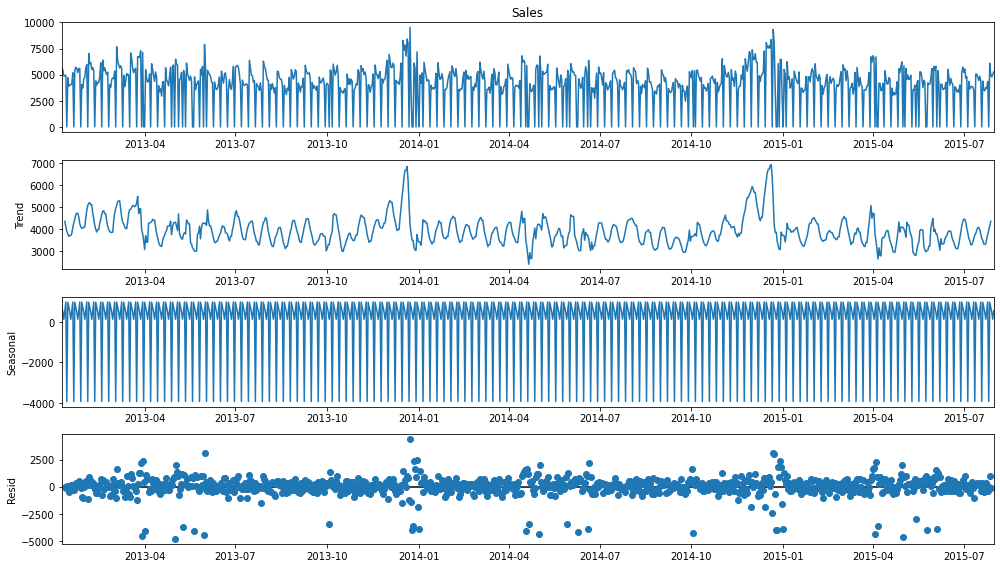

In [38]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df_store_1["Sales"], model="additive")

resplot = res.plot()

### Formula
### Prediction = constant + linear combination lags of Y + linear combination of lagged forecast errors

### Ad Fuller test to check the stationarity : Constant mean Constant variance needed for ARIMA

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

In [40]:
result = adfuller(train["Sales"])

print("ADF :", result[0])
print("p-value : ", result[1])
print("critical values: ")
for key, val in result[4].items():
    print(f"\t%s: %.3f" % (key, val))
    

ADF : -2.560472863337092
p-value :  0.10144496506198097
critical values: 
	1%: -3.450
	5%: -2.870
	10%: -2.571


### ACF and PACF : Past can be used to predict or not

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



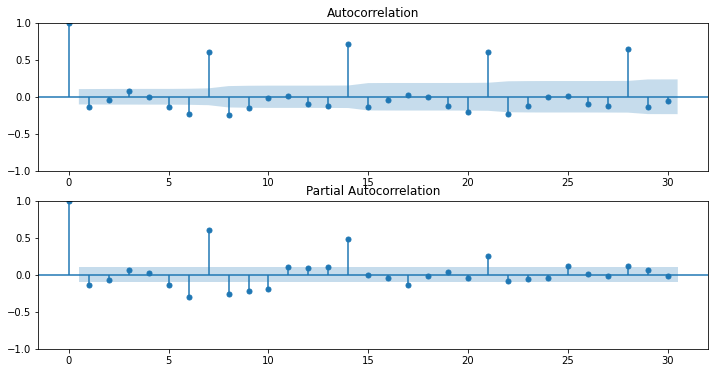

In [41]:
 from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12, 6))
ax[0] = plot_acf(train["Sales"], ax=ax[0], lags=30)
ax[1] = plot_pacf(train["Sales"], ax=ax[1], lags=30)

### Params search: GRID : Dont run

In [ ]:
import itertools    

p = d = q = range(0,4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 1) for x in list(itertools.product(p,d,q))]

In [ ]:
from sklearn.metrics import mean_squared_error

metric_aic_dict = dict()


for pm in pdq:
    for pm_seasonal in seasonal_pdq:
        try:
            model = river.time_series.SNARIMAX(p=pm[0], d=pm[1], q=pm[2], sp=pm_seasonal[0], sd=pm_seasonal[1], sq=pm_seasonal[2], m=pm_seasonal[3])
            # train
            for a,b in enumerate(train.iterrows()):
                model.learn_one(b[1][-1])
            forecast = model.forecast(horizon=365)
            # mse calc
            mse = mean_squared_error(test["Sales"], forecast)
            print(pm, pm_seasonal, mse)
            metric_aic_dict.update({(pm, pm_seasonal) : mse})
        except:
            continue

In [ ]:
{k: v for k,v in sorted(metric_aic_dict.items(), key=lambda x:x[1])}

In [ ]:
# Best Params : ((0, 0, 0), (1, 1, 0, 7))

model = river.time_series.SNARIMAX(
    p=0,
    d=0,
    q=0,
    sp=1,
    sd=1,
    sq=0,
    m=7

)


In [ ]:

model = river.time_series.SNARIMAX(
    p=1,
    d=1,
    q=1

)

In [ ]:
# dir(model)

In [ ]:
for a,b in enumerate(train.iterrows()):
    model.learn_one(b[1][-1])


In [ ]:

f = []
future = []
for a,b in enumerate(test.iterrows()):
#     print(type(b[1][0].date()))
    x = b[1][0].date()
    f.append(x)
    dd = {"Date" : x}
    future.append(dd)
    


In [ ]:
# future

In [ ]:

forecast = model.forecast(horizon=365)

In [ ]:
#forecast

In [ ]:
# for x, y_pred in zip(future, forecast):
#     print(x['Date'], f'{y_pred:.3f}')

In [ ]:

# for x, y_pred in zip(future, forecast):
#     print(type(x), type(y_pred))
#     break


# df_pred_batch = {"Date":f, "sales_pred_batch":forecast}
# df_pred_batch = pd.DataFrame(df_pred_batch)

# df_pred_batch



test_new = test.copy()

test_new["sales_pred_batch"] = forecast


In [ ]:

test_idx = test_new[["Date", "Sales", "sales_pred_batch"]].set_index("Date")
test_idx.plot()

# df_2013 = df_store_1["2013"]
# prom_df_2013 = df_2013[["Sales", "Promo"]]
# prom_df_2013.plot(subplots=True)

## Search Params : Try #2

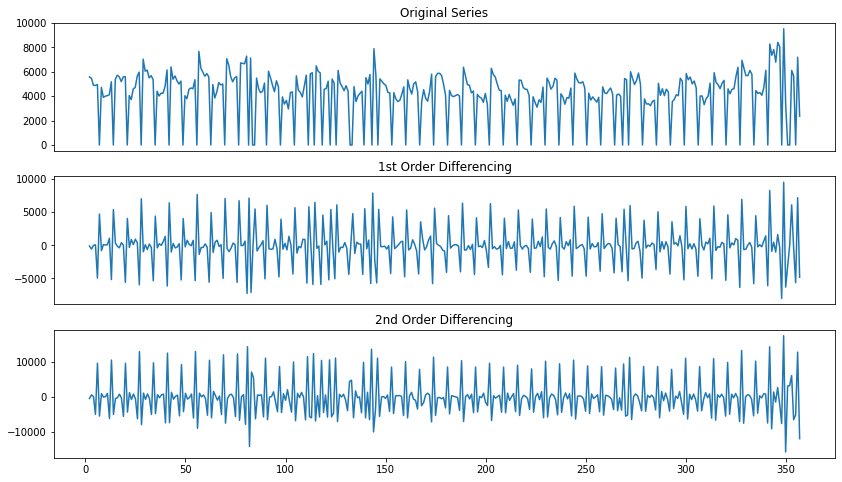

In [42]:
# Finding : d = 2

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
# plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(train.Sales); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(train.Sales.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(train.Sales.diff().diff()); ax3.set_title('2nd Order Differencing');#ax3.axes.xaxis.set_visible(False)
plt.show()
#3rd Differencing
# ax4.plot(train.Sales.diff().diff().diff()); ax4.set_title('3rd Order Differencing')
# plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

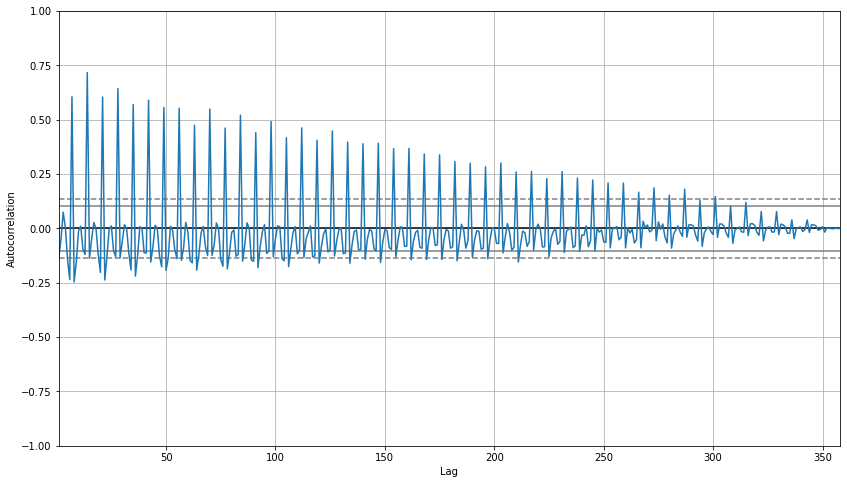

In [43]:
# from statsmodels.graphics.tsaplots import plot_acf
# fig, (ax1, ax2, ax3) = plt.subplots(3)
# plot_acf(train.Sales, ax=ax1)
# plot_acf(train.Sales.diff().dropna(), ax=ax2)
# plot_acf(train.Sales.diff().diff().dropna(), ax=ax3)

# pd.plotting.lag_plot(train.Sales,lag=1)

pd.plotting.autocorrelation_plot(train.Sales)


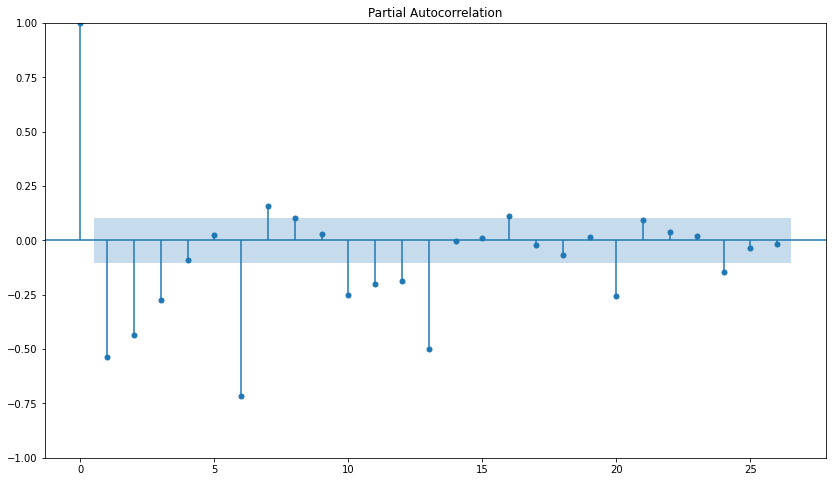

In [44]:
# p = 1
plot_pacf(train.Sales.diff().dropna())
plt.show()

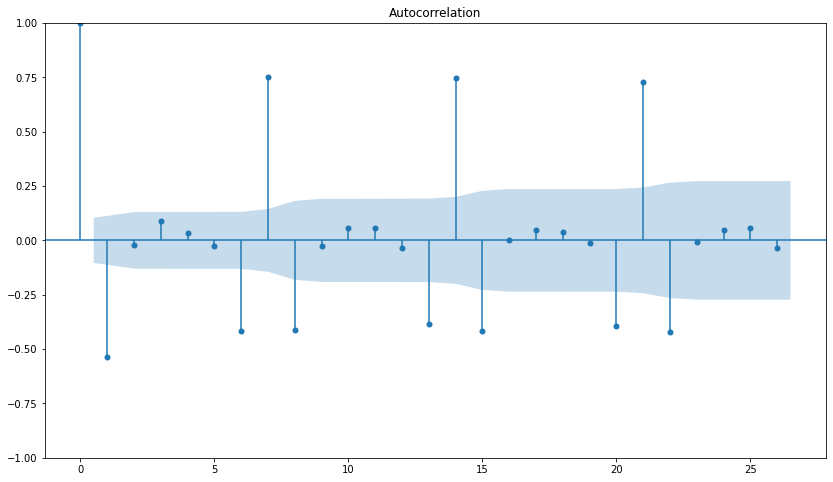

In [45]:
# q = 1
plot_acf(train.Sales.diff().dropna())
plt.show()


# Search Params: Try #3 Success

In [115]:
# Grid Search
import pmdarima as pm

model = pm.auto_arima(df_store_1["Sales"],
                     m=7,
                     seasonal=True,
                     start_p=0,
                     start_q=0,
                     max_order=8,
                     test="adf",
                     error_action="ignore",
                     suppress_warmnings=True,
                      stepwise=True, trace=True
                     )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=7.13 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=16862.505, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=16737.190, Time=0.78 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=16649.479, Time=1.56 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=18335.635, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=16849.261, Time=0.08 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=16630.416, Time=3.54 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=16799.781, Time=0.80 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=6.67 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=16428.188, Time=6.74 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=16432.449, Time=2.67 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=16358.256, Time=6.84 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=7.47 sec
 ARIMA(1,0,1)(2,0,2)[7] intercept   : AIC=inf, Time=8.56 sec
 ARIMA(0,0,2)(2,0,2)[7] intercept   : AIC=1

Best model:  ARIMA(0,0,1)(2,0,2)[7] intercept
Total fit time: 92.987 seconds


In [116]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  934
Model:             SARIMAX(0, 0, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -8172.128
Date:                                Wed, 07 Dec 2022   AIC                          16358.256
Time:                                        04:25:12   BIC                          16392.132
Sample:                                    01-09-2013   HQIC                         16371.173
                                         - 07-31-2015                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3932.8936    313.071     12.562      0.000    3319.285    4546.502
ma.L1          0.0523      0.026      2.021      0.043       0.002       0.103
ar.S.L7       -0.3135      0.057     -5.495      0.000      -0.425      -0.202
ar.S.L14       0.4113      0.051      8.026      0.000       0.311       0.512
ma.S.L7        0.7203      0.061     11.747      0.000       0.600       0.840
ma.S.L14       0.1289      0.056      2.302      0.021       0.019       0.239
sigma2        2.3e+06   9.75e+04     23.600      0.000    2.11e+06    2.49e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                99.30
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.50
Prob(H) (two-sided):                  0.24   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Online Learning:
    - We have two mode to learn:
        1. Batch learn -> Predict test
        2. Batch learn -> Predict One test -> Learn One test

##  1. Batch learn -> Predict test


Above we see : Best model:  ARIMA(0,0,1)(2,0,2)[7] intercept


In [166]:
# model = river.time_series.SNARIMAX( p=8, d=1, q=1)
model = river.time_series.SNARIMAX(p=0,d=0,q=1, m=7,sp=2, sd=0, sq=2)


In [167]:
# Only Train
for a,b in enumerate(train.iterrows()):
    model.learn_one(b[1][-1])

In [168]:
f = []
future = []
for a,b in enumerate(test.iterrows()):
    x = b[1][0].date()
    f.append(x)
    dd = {"Date" : x}
    future.append(dd)
    
# print(f)
# print(future)

In [169]:
# Forecast for 365 days
forecast = model.forecast(horizon=365)
# forecast

# Alternative : Straight Line Prediction
# forecast = []

# for i in range(len(test)):
#     # Predict only 1 future value:
#     single = model.forecast(horizon=1)
#     forecast.append(single[0])

In [170]:
test_new = test.copy()

test_new["sales_batch_pred"] = forecast

<AxesSubplot:xlabel='Date'>

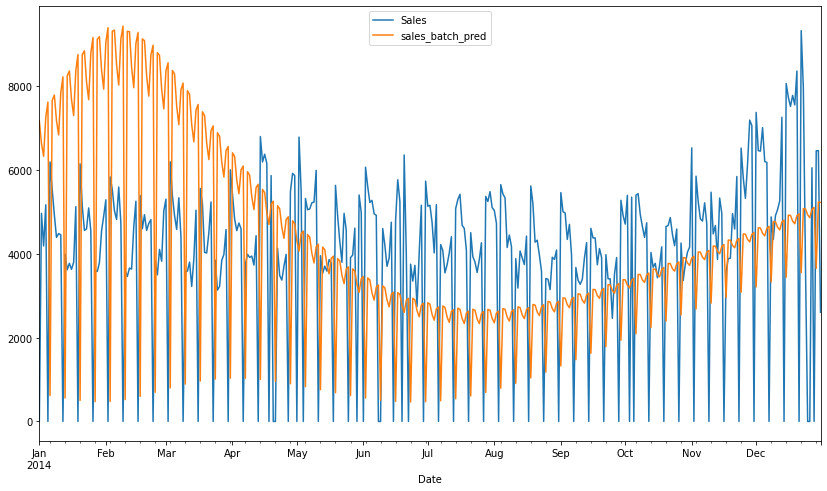

In [171]:
test_idx = test_new[["Date", "Sales", "sales_batch_pred"]].set_index("Date")
test_idx.plot()

In [172]:
model._get_params()

{'p': 0,
 'd': 0,
 'q': 1,
 'm': 7,
 'sp': 2,
 'sd': 0,
 'sq': 2,
 'regressor': (river.compose.pipeline.Pipeline,
  {'StandardScaler': {'with_std': True},
   'LinearRegression': {'optimizer': (river.optim.sgd.SGD,
     {'lr': (river.optim.schedulers.Constant, {'learning_rate': 0.01})}),
    'loss': (river.optim.losses.Squared, {}),
    'l2': 0.0,
    'intercept_init': 0.0,
    'intercept_lr': (river.optim.schedulers.Constant, {'learning_rate': 0.01}),
    'clip_gradient': 1000000000000.0,
    'initializer': (river.optim.initializers.Zeros, {})}})}


# 2. Batch learn -> Predict One test -> Learn One test

Above we see : Best model:  ARIMA(0,0,1)(2,0,2)[7] intercept


In [173]:
# model = river.time_series.SNARIMAX(
#     p=8,
#     d=1,
#     q=1

# )

model = river.time_series.SNARIMAX(p=0,d=0,q=1, m=7,sp=2, sd=0, sq=2)

# Learn-one at a time, Batch size = 1
for a,b in enumerate(train.iterrows()):
    model.learn_one(b[1][-1])

In [174]:
model._get_params()

{'p': 0,
 'd': 0,
 'q': 1,
 'm': 7,
 'sp': 2,
 'sd': 0,
 'sq': 2,
 'regressor': (river.compose.pipeline.Pipeline,
  {'StandardScaler': {'with_std': True},
   'LinearRegression': {'optimizer': (river.optim.sgd.SGD,
     {'lr': (river.optim.schedulers.Constant, {'learning_rate': 0.01})}),
    'loss': (river.optim.losses.Squared, {}),
    'l2': 0.0,
    'intercept_init': 0.0,
    'intercept_lr': (river.optim.schedulers.Constant, {'learning_rate': 0.01}),
    'clip_gradient': 1000000000000.0,
    'initializer': (river.optim.initializers.Zeros, {})}})}

In [175]:
forecast_train = []

for a, b in enumerate(test.iterrows()):
    
    # Predict only 1 future value:
    single = model.forecast(horizon=1)
    forecast_train.append(single[0])
    
    # Learn from one test data:
    model.learn_one(b[1][-2])


In [176]:
test_new["sales_pred_train"] = forecast_train

<AxesSubplot:xlabel='Date'>

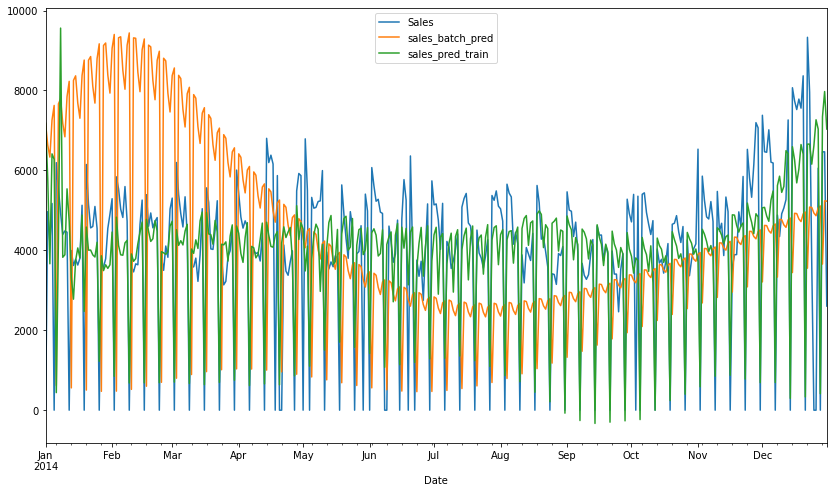

In [177]:
test_idx = test_new[["Date", "Sales", "sales_batch_pred", "sales_pred_train"]].set_index("Date")

# test_idx = test_new[["Date", "Sales", "sales_pred_train"]].set_index("Date")

test_idx.plot()

In [178]:

import plotly.graph_objects as go

fig_1 = px.line(test_idx.reset_index(), x=test_idx.reset_index().Date, y='Sales', title='Store 1: Sales with Slider')
fig_1.update_traces(line=dict(color = 'blue'))

fig_2 = px.line(test_idx.reset_index(), x=test_idx.reset_index().Date, y='sales_batch_pred')
fig_2.update_traces(line=dict(color = 'red'))

fig_3 = px.line(test_idx.reset_index(), x=test_idx.reset_index().Date, y='sales_pred_train')
fig_3.update_traces(line=dict(color = 'orange'))


fig_4 = go.Figure(data=fig_1.data + fig_2.data + fig_3.data)

fig_4.update_xaxes(rangeslider_visible=True)

fig_4.show()

In [179]:
# Exclude Store closed day
test_no_zero = test_idx.query("Sales != 0")

print(f"sales_pred_train RMSE : {np.sqrt(mse(test_no_zero.Sales, test_no_zero.sales_pred_train))}")

print(f"sales_batch_pred RMSE : {np.sqrt(mse(test_idx.Sales, test_idx.sales_batch_pred))}")


sales_pred_train RMSE : 1087.7455241370506
sales_batch_pred RMSE : 3193.7611862628364


<AxesSubplot:xlabel='Date'>

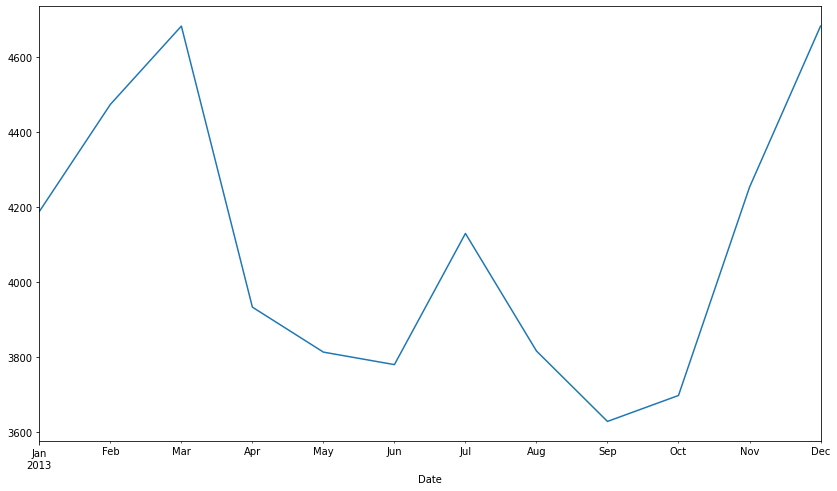

In [155]:
train_resampled = train.set_index("Date")
train_resampled = train_resampled.resample("M").mean()

train_resampled["Sales"].plot()

In [156]:
train_resampled.describe()

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,dayofweek,quarter,month,year,...,dayofmonth,weekofyear,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0,...,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,3.999334,4090.241449,490.681253,0.833050,0.371651,0.207554,2.999334,2.500000,6.500000,2013.0,...,16.041667,26.369335,4099.792862,4102.119903,4098.718258,4097.992023,4097.819571,4108.297684,4123.600303,4109.973794
std,0.122569,372.440640,43.788056,0.040927,0.050619,0.262473,0.122569,1.167748,3.605551,0.0,...,1.322160,15.165082,416.597782,391.916729,434.611919,408.253989,369.345512,387.105046,374.102876,401.841398
min,3.806452,3628.900000,440.400000,0.741935,0.322581,0.000000,2.806452,1.000000,1.000000,2013.0,...,14.500000,3.434783,3669.866667,3566.935484,3581.064516,3616.935484,3676.709677,3636.032258,3747.483871,3719.870968
25%,3.927419,3805.373925,451.795968,0.826613,0.333333,0.000000,2.927419,1.750000,3.750000,2013.0,...,15.500000,14.564516,3746.702688,3846.201613,3849.808333,3817.600000,3859.695968,3872.103495,3855.508333,3862.048656
50%,4.000000,4031.848925,477.022581,0.836022,0.352484,0.145863,3.000000,2.500000,6.500000,2013.0,...,16.000000,26.537634,3996.894624,3944.661290,3893.240323,3974.558602,3960.716667,3959.550000,4049.075269,3966.233333
75%,4.097581,4308.391071,525.616071,0.867391,0.404839,0.314516,3.097581,3.250000,9.250000,2013.0,...,16.000000,38.592742,4288.546584,4372.897904,4250.814441,4281.683618,4427.966227,4389.743789,4378.731066,4223.158385
max,4.193548,4682.870968,566.903226,0.870968,0.483871,0.838710,3.193548,4.000000,12.000000,2013.0,...,20.000000,47.225806,4833.709677,4761.580645,4910.419355,4875.000000,4813.419355,4961.806452,4961.806452,5029.322581


<AxesSubplot:xlabel='Date'>

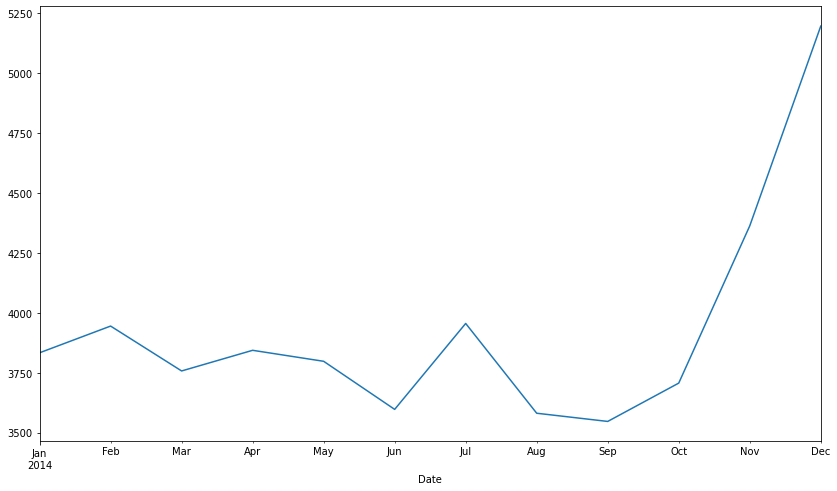

In [152]:
test_resampled = test.set_index("Date")
test_resampled = test_resampled.resample("M").mean()

test_resampled["Sales"].plot()

In [159]:
test_resampled.describe()

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,dayofweek,quarter,month,year,...,dayofmonth,weekofyear,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0,...,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,3.997043,3926.313031,462.391372,0.830210,0.383705,0.224642,2.997043,2.500000,6.500000,2014.0,...,15.708333,26.325115,3925.500774,3927.239836,3909.269643,3924.667812,3924.713402,3924.249155,3923.676242,3922.737039
std,0.121829,455.299134,45.815116,0.030292,0.049308,0.293805,0.121829,1.167748,3.605551,0.0,...,0.450168,15.042174,458.640065,447.285274,448.872026,484.433615,474.554501,518.073885,586.137893,563.018064
min,3.806452,3546.600000,414.733333,0.766667,0.322581,0.000000,2.806452,1.000000,1.000000,2014.0,...,14.500000,3.000000,3382.633333,3343.100000,3472.066667,3472.266667,3459.933333,3491.066667,3491.366667,3377.800000
25%,3.902419,3678.974462,433.268280,0.806452,0.354839,0.000000,2.902419,1.750000,3.750000,2014.0,...,15.500000,14.704839,3729.475806,3766.048118,3642.081183,3730.645161,3721.981452,3720.266129,3707.330645,3657.564516
50%,4.000000,3814.983871,452.806452,0.838710,0.376882,0.131720,3.000000,2.500000,6.500000,2014.0,...,16.000000,26.685484,3788.225806,3817.145161,3814.516129,3799.290323,3828.822581,3815.741935,3787.096774,3804.435484
75%,4.072581,3946.795507,470.474654,0.843318,0.404839,0.338710,3.072581,3.250000,9.250000,2014.0,...,16.000000,38.750000,3948.544067,3878.034562,3970.397753,3900.644297,3890.603111,3885.716014,3908.810714,3941.840150
max,4.193548,5194.387097,585.806452,0.870968,0.500000,1.000000,3.193548,4.000000,12.000000,2014.0,...,16.000000,46.333333,5110.354839,5129.709677,5153.322581,5351.516129,5328.000000,5515.580645,5726.129032,5608.096774


In [182]:
fig_1 = px.line(train_resampled, x=range(0,len(train_resampled.reset_index().Date)), y='Sales')
fig_1.update_traces(line=dict(color = 'orange'))


fig_2 = px.line(test_resampled, x=range(0,len(test_resampled.reset_index().Date)), y='Sales')
fig_2.update_traces(line=dict(color = 'blue'))

fig_4 = go.Figure(data=fig_1.data + fig_2.data)

fig_4.update_xaxes(rangeslider_visible=True)

fig_4.show()

In [144]:
#TEST

fig_1 = px.line(test_idx.reset_index(), x=range(0,len(test_idx.reset_index().Date)), y='Sales')
fig_1.update_traces(line=dict(color = 'orange'))


fig_2 = px.line(train.reset_index(), x=range(0,len(train.reset_index().Date)), y='Sales')
fig_2.update_traces(line=dict(color = 'blue'))

fig_4 = go.Figure(data=fig_1.data + fig_2.data)

fig_4.update_xaxes(rangeslider_visible=True)

fig_4.show()

In [135]:
#TEST
!pip install data-drift-detector


  Preparing metadata (setup.py) ... done
  Created wheel for data-drift-detector: filename=data_drift_detector-0.0.13-py3-none-any.whl size=8889 sha256=34d939f446febe3f87fdfb5800cf6f5e8f4f649a03125c55b962780a1a84e2ec
  Stored in directory: /root/.cache/pip/wheels/64/8b/36/85a33d2cca8e452893b449826112b1772c9ae0f08df9b16e75
Successfully built data-drift-detector


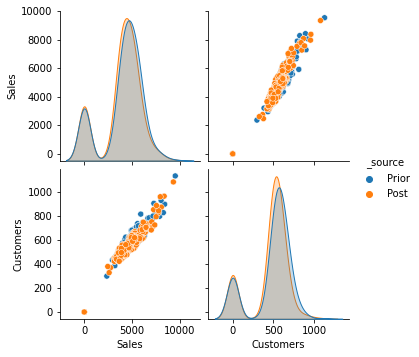

In [184]:
from data_drift_detector import DataDriftDetector
detector = DataDriftDetector(df_prior = train[["Sales", "Customers"]], df_post = test[["Sales","Customers"]])

detector.plot_numeric_to_numeric()


# XGBOOST

<b>Idea: Train and Save on the first batch. On Next run, pass saved model path to "xgb.train" method.

Algorithm:
 - Batch Train the model on Train (2013)
 - Test data divide into months chunk
 - Incremental Way:
     -for each month:
         - predict the month
         - error measure (yhat-y)
         - train on that month
 - Not learning:
     -for each month:
             - predict the month
             - error measure (yhat-y)

In [185]:
os.remove("/kaggle/working/model_1.model")
os.remove("/kaggle/working/model_1_re.model")
os.remove("/kaggle/working/model_1_re_month.model")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/model_1.model'

In [189]:
train.drop("StateHoliday", axis=1, inplace=True)
test.drop("StateHoliday", axis=1, inplace=True)

In [190]:
# Train-Val
X_train = train.set_index("Date")["2013-01":"2013-11"]
X_val = train.set_index("Date")["2013-12"]

y_train = train.set_index("Date")["2013-01":"2013-11"][["Sales"]]
y_val = train.set_index("Date")["2013-12"][["Sales"]]



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



In [191]:
X_train = X_train.drop("Sales", axis=1)
X_val = X_val.drop("Sales", axis=1)


In [192]:
# Features = ["DayOfWeek", "Customers", "Open", "Promo", "StateHoliday", "quarter", "Lag_1"]

# X_train = X_train[Features]
# X_val = X_val[Features]

# Y = train[["Sales"]]

xg_train = xgb.DMatrix(X_train, label=y_train)
xg_val = xgb.DMatrix(X_val, label=y_val)

In [193]:
# 1 . Batch Train the model on Train (2013)


params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth' : 1000}
model_1 = xgb.train(params,
                    xg_train,
                    num_boost_round=1000,
                    evals=[(xg_val, 'validation')],
                    early_stopping_rounds=50 
                   )

# Model save
model_1.save_model('model_1.model') # No re-learning
model_1.save_model('model_1_re.model') # pred->learning 
model_1.save_model('model_1_re_month.model') # month based retraining->prediction

model_2 = copy.deepcopy(model_1)
model_3 = copy.deepcopy(model_1)

[0]	validation-rmse:4190.07321
[1]	validation-rmse:3206.35275
[2]	validation-rmse:2431.53139
[3]	validation-rmse:1884.13499
[4]	validation-rmse:1568.46238
[5]	validation-rmse:1350.71812
[6]	validation-rmse:1202.71506
[7]	validation-rmse:1102.63045
[8]	validation-rmse:1030.90717
[9]	validation-rmse:974.69071
[10]	validation-rmse:931.53114
[11]	validation-rmse:905.73476
[12]	validation-rmse:868.29023
[13]	validation-rmse:852.89231
[14]	validation-rmse:836.68624
[15]	validation-rmse:832.05137
[16]	validation-rmse:821.87895
[17]	validation-rmse:820.40863
[18]	validation-rmse:819.17166
[19]	validation-rmse:818.07657
[20]	validation-rmse:813.61106
[21]	validation-rmse:812.96005
[22]	validation-rmse:812.65165
[23]	validation-rmse:812.27811
[24]	validation-rmse:811.96077
[25]	validation-rmse:811.57980
[26]	validation-rmse:811.36831
[27]	validation-rmse:811.24819
[28]	validation-rmse:811.10753
[29]	validation-rmse:810.90880
[30]	validation-rmse:810.80801
[31]	validation-rmse:810.76696
[32]	vali

In [ ]:
# test.columns

###  Pred - Retrain Model: 

In [194]:

# Retrain Model

test_train = test.copy()

test_train = test_train.set_index("Date")
yr = "2014"
month = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

errors = []

for m in month:
    # 1 month Data
    df = test_train[yr+"-"+m]
    x_test = df.drop("Sales", axis=1)
    y_test = df[["Sales"]]
    
    xg_test = xgb.DMatrix(x_test, label=y_test)
    
    # Error 
#     mae_ = mae(model_1.predict(xg_test), y_test)
    rmse = np.sqrt(mse(model_1.predict(xg_test), y_test))
    
#     errors.append(rmse)
    
    if len(errors) <= 0:
        print(f"First Iteraion, Rmse : {rmse} => Retrain")
        model_1 = xgb.train(params,
                            xg_test,
                            num_boost_round=1000,
                            xgb_model='model_1_re.model')
        # Save the updated model
        model_1.save_model('model_1_re.model')
    
    elif errors[-1] <= rmse: # If the prev retrain works, Means retraining working
        print(f"{errors[-1]} <= {rmse} => Retrain")
        # Train on the Unseen data
        model_1 = xgb.train(params,
                            xg_test,
                            num_boost_round=1000,
                            xgb_model='model_1_re.model')
        # Save the updated model
        model_1.save_model('model_1_re.model')
        
    else:
        print(f"{errors[-1]} < {rmse} => No retrain")
        # Train on the Unseen data
#         model_1 = xgb.train(params,
#                             xg_test,
#                             num_boost_round=1000)
    
        
    
    errors.append(rmse)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



First Iteraion, Rmse : 258.30962395343926 => Retrain


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



258.30962395343926 <= 431.54631884126815 => Retrain


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



431.54631884126815 < 373.4127808405563 => No retrain
373.4127808405563 <= 421.6582794874101 => Retrain


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



421.6582794874101 < 351.7560013745507 => No retrain
351.7560013745507 <= 420.1529761506882 => Retrain


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



420.1529761506882 <= 444.34963614814484 => Retrain


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



444.34963614814484 < 393.8310111590679 => No retrain
393.8310111590679 <= 478.3909177111511 => Retrain


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



478.3909177111511 <= 591.9866493385719 => Retrain


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



591.9866493385719 <= 878.8766823579915 => Retrain
878.8766823579915 < 807.3691196966945 => No retrain


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



### Only predict, no retrain

In [195]:
# No Retrain : Model_2

test_train = test.copy()

test_train = test_train.set_index("Date")
yr = "2014"
month = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

errors_batch = []

for m in month:
    df = test_train[yr+"-"+m]
    
    x_test = df.drop("Sales", axis=1)
    y_test = df[["Sales"]]
    
    xg_test = xgb.DMatrix(x_test, label=y_test)
    
#     mae_ = mae(model_2.predict(xg_test), y_test)
#     errors_batch.append(mae_)
    rmse = np.sqrt(mse(model_2.predict(xg_test), y_test))
    errors_batch.append(rmse)
    print(f"Rmse {rmse}")
#     print(f"Month {m}, Mae: {mae_}")
    
#     model_2 = xgb.train(params, xg_train_df, 300) #, xgb_model='model_1.model')
#     model_1.save_model('model_1.model')
    

Rmse 258.30962395343926
Rmse 249.9283236621397
Rmse 216.49372460149687
Rmse 276.3357458573883
Rmse 219.4966790887103
Rmse 272.4443973221099
Rmse 254.40393599268293
Rmse 231.3080535868809
Rmse 279.5801154569952
Rmse 270.3704770441749
Rmse 382.3707904368438
Rmse 1050.062670195229


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice t

### Retrain based on same Month

In [198]:
# Retrain monthly

test_cpy = test.copy()
test_cpy = test_cpy.set_index("Date")

train_cpy = train.copy()
train_cpy = train_cpy.set_index("Date")

yr_train = "2013"
yr_test = "2014"
month = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

errors_re_monthly = []

for m in month:
    # 1 month Data
    df_train = train_cpy[yr_train + "-" + m]
    df = test_cpy[yr + "-" + m]
    
    x_train = df_train.drop("Sales", axis=1)
    y_train = df_train[["Sales"]]
    
    x_test = df.drop("Sales", axis=1)
    y_test = df[["Sales"]]
    
    xg_train = xgb.DMatrix(x_train, label=y_train)
    xg_test = xgb.DMatrix(x_test, label=y_test)
    
    
    model_3 = xgb.train(params,
                        xg_train,
                        num_boost_round=1000)
#                             xgb_model='model_1_re_month.model')
    
    # Error 
    rmse = np.sqrt(mse(model_3.predict(xg_test), y_test))    
        
    
    errors_re_monthly.append(rmse)
    model_3.save_model("model_1_re_month.model")
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice t

In [199]:
err_df = pd.DataFrame({"Online_err":errors, "Batch_err":errors_batch, "monthly_based_training":errors_re_monthly})
err_df

,Online_err,Batch_err,monthly_based_training
0,258.309624,258.309624,833.960112
1,431.546319,249.928324,410.149188
2,373.412781,216.493725,519.335954
3,421.658279,276.335746,354.750297
4,351.756001,219.496679,455.569896
5,420.152976,272.444397,1010.568796
6,444.349636,254.403936,249.446250
7,393.831011,231.308054,346.429088
8,478.390918,279.580115,292.920479
9,591.986649,270.370477,350.601368


<AxesSubplot:>

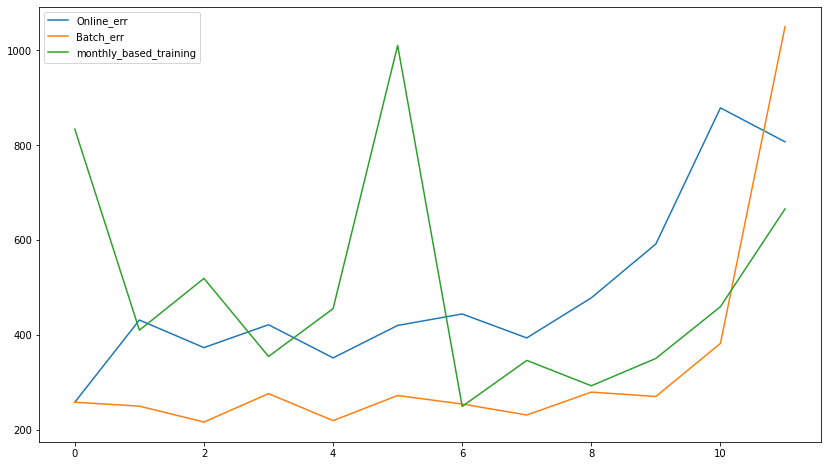

In [200]:
err_df.plot()

In [ ]:
First Iteraion, Rmse : 240.26821289637468
240.26821289637468 <= 332.5751504078399 => Retrain
332.5751504078399 < 291.99563802960813 => No retrain
291.99563802960813 <= 418.606015089084 => Retrain
418.606015089084 < 339.52815886979386 => No retrain
339.52815886979386 <= 487.00287293229786 => Retrain
487.00287293229786 < 381.3792266516703 => No retrain
381.3792266516703 <= 396.2939201794946 => Retrain
396.2939201794946 <= 440.1687762663778 => Retrain
440.1687762663778 <= 700.9055219305193 => Retrain
700.9055219305193 < 634.6346143269408 => No retrain
634.6346143269408 <= 1554.7379526945297 => Retrain


In [ ]:
#TEST
# xgb.train()
# test_train
# df
# import os
# model_2.best_iteration
os.remove("/kaggle/working/model_1.model")

## **half Space trees**

In [ ]:
from skmultiflow.data import AnomalySineGenerator
from skmultiflow.anomaly_detection import HalfSpaceTrees

# Setup a data stream
stream = AnomalySineGenerator(random_state=1, n_samples=1000, n_anomalies=250)

stream

In [ ]:
# Setup Half-Space Trees estimator
half_space_trees = HalfSpaceTrees(random_state=1)
# Setup variables to control loop and track performance
max_samples = 1000
n_samples = 0
true_positives = 0
detected_anomalies = 0
# Train the estimator(s) with the samples provided by the data stream
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    y_pred = half_space_trees.predict(X)
    if y[0] == 1:
        true_positives += 1
        if y_pred[0] == 1:
            detected_anomalies += 1
    half_space_trees.partial_fit(X, y)
    n_samples += 1
print('{} samples analyzed.'.format(n_samples))
print('Half-Space Trees correctly detected {} out of {} anomalies'.
      format(detected_anomalies, true_positives))